# Introduction and Objective

This notebook presents a way to generate relevant tags for movies using the BERTopic model. We'll use a dataset which contains movie plots scraped from Wikipedia  and employ natural language processing techniques to prepare the data for model training.

The source of the CSV data file used in this notebook is [here](https://www.kaggle.com/datasets/jrobischon/wikipedia-movie-plots)

# Library Imports

All libraries and dependencies needed in the notebook:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sentence_transformers import SentenceTransformer
import torch
import umap
from wordcloud import WordCloud

# Data Loading and Overview

This section will involve loading the dataset, and doing basic EDA to get an overview of the dataset.

In [2]:
df = pd.read_csv('~/Desktop/Brainstation/Capstone/NLP/plots/wiki_movie_plots_deduped.csv')

In [3]:
df.head(5)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


Dropping rows that are not relevant to the goal of deriving insights from the plots of the movies.

In [4]:
df.drop(['Origin/Ethnicity', 'Director', 'Cast', 'Genre', 'Wiki Page'], axis=1, inplace=True)

Look into the 'Plot' columns data.

In [5]:
df['Plot']

0        A bartender is working at a saloon, serving dr...
1        The moon, painted with a smiling face hangs ov...
2        The film, just over a minute long, is composed...
3        Lasting just 61 seconds and consisting of two ...
4        The earliest known adaptation of the classic f...
                               ...                        
34881    The film begins in 1919, just after World War ...
34882    Two musicians, Salih and Gürkan, described the...
34883    Zafer, a sailor living with his mother Döndü i...
34884    The film centres around a young woman named Am...
34885    The writer Orhan Şahin returns to İstanbul aft...
Name: Plot, Length: 34886, dtype: object

In [6]:
df['Plot'][0]

"A bartender is working at a saloon, serving drinks to customers. After he fills a stereotypically Irish man's bucket with beer, Carrie Nation and her followers burst inside. They assault the Irish man, pulling his hat over his eyes and then dumping the beer over his head. The group then begin wrecking the bar, smashing the fixtures, mirrors, and breaking the cash register. The bartender then sprays seltzer water in Nation's face before a group of policemen appear and order everybody to leave.[1]"

In [7]:
df.shape

(34886, 3)

Looking at our newly modified dataframe. 

Release Year and Title are being kept in order to merge this dataframe with the dataframe which contains movie posters in order to generate a multimodal dataframe (containing text from this section, and images from the poster dataframe). Once again to clarify, this notebooks goal is to modify this plot dataframe to merge in the Predicting Plot Topics notebook.

In [8]:
df.head(5)

,Release Year,Title,Plot
0,1901,Kansas Saloon Smashers,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,The earliest known adaptation of the classic f...


# Data Cleaning and Preprocessing

In [9]:
# Convert text to Lowercase
df['Plot'] = df['Plot'].str.lower()

# Remove punctuation
df['Plot'] = df['Plot'].str.replace('[{}]'.format(string.punctuation), '', regex=True)

# Tokenization
df['Plot'] = df['Plot'].apply(word_tokenize)

# Remove stop words
stop_words = set(stopwords.words('english'))
df['Plot'] = df['Plot'].apply(lambda x: [word for word in x if word not in stop_words])

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['Plot'] = df['Plot'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Calculate word frequencies
all_words = [word for plot in df['Plot'] for word in plot]
word_counts = Counter(all_words)

# Print the most common words
print(word_counts.most_common(10))

# Print the least common words
print(word_counts.most_common()[-10:])


[('find', 30546), ('get', 29690), ('one', 29510), ('go', 27267), ('take', 26798), ('tell', 23549), ('father', 23485), ('back', 22542), ('love', 22456), ('life', 21758)]
[('asli', 1), ('merit4', 1), ('instead31', 1), ('similarities1', 1), ('axani', 1), ('reddit', 1), ('notransfer', 1), ('buzzfeed', 1), ('viral6', 1), ('soysal', 1)]


Creating a word cloud to visualize the plot descriptions

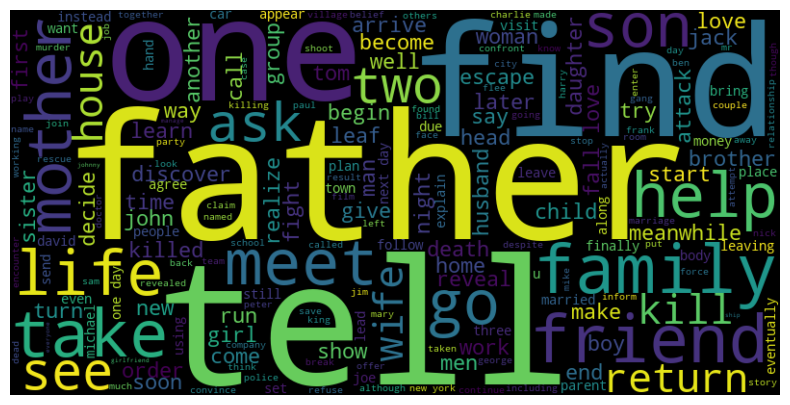

In [10]:
all_words_str = ' '.join(all_words)
wordcloud = WordCloud(width=800, height=400).generate(all_words_str)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [11]:
df['Plot'] = df['Plot'].apply(' '.join)

# Topic Modeling

The purpose of this section is to demonstrate the use of the BERTopic model to generate relevant topics for movie descriptions. This process is an essential part of text analysis and natural language processing, allowing us to group similar texts based on shared themes. The code blocks provided here outline the necessary steps to implement this model.

### Creating a UMAP (Uniform Manifold Approximation and Projection) model
UMAP is a dimension reduction technique that can be used to reduce the complexity of high-dimensional data. Here, the parameters selected (n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=1) were determined based on some exploratory testing and analysis to ensure optimal performance of the model.

In [12]:
# Create a UMAP model
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=1)

### Creating HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) model

HDBSCAN is a clustering algorithm that works well with data of varying densities. In this case, we've set min_cluster_size=50, which was chosen to ensure each topic cluster includes at least 50 movies. This helps to generate interpretable topics that are representative of the larger medium.

In [13]:
# Create a HDBSCAN model
hdbscan_model = HDBSCAN(min_cluster_size=50, metric='manhattan', prediction_data=True)

### Creating BERTopic model using UMAP and HDBSCAN models

In [14]:
# Create a BERTopic model w/ UMAP and HDBSCAN models
model_bertopic = BERTopic(language="english", calculate_probabilities=True, verbose=True,
                 umap_model=umap_model, hdbscan_model=hdbscan_model)

# Use the model to find topics
topics, probabilities = model_bertopic.fit_transform(df['Plot'])

Batches:   0%|          | 0/1091 [00:00<?, ?it/s]

2023-07-04 22:28:46,609 - BERTopic - Transformed documents to Embeddings
2023-07-04 22:29:26,387 - BERTopic - Reduced dimensionality
2023-07-04 22:29:33,375 - BERTopic - Clustered reduced embeddings


### Displaying topics found with BERTopic model

Next, we will display the topics found from the model.

In [15]:
# Get an overview of the topics
model_bertopic.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,16916,-1_get_find_one_go,"[get, find, one, go, father, take, love, life,...",[start film krishna set fire bullying elder br...
1,0,3887,0_tell_find_go_house,"[tell, find, go, house, home, one, get, car, t...",[story told point view howard wakefield narrat...
2,1,2361,1_love_story_life_film,"[love, story, life, film, village, family, fal...",[story open car accident rupa nargis bagheri p...
3,2,1779,2_german_ship_war_captain,"[german, ship, war, captain, island, crew, sol...",[1944 united state army air force usaaf air ba...
4,3,1432,3_hong_li_kong_lee,"[hong, li, kong, lee, master, wong, chinese, c...",[armoured truck carrying 100 million cash atta...
5,4,854,4_murder_police_detective_crime,"[murder, police, detective, crime, gang, crimi...",[pair brother paid take care confectionery box...
6,5,823,5_love_get_family_father,"[love, get, family, father, marriage, raja, ma...",[story start vasu vaibhav narrating story chil...
7,6,733,6_husband_wife_love_life,"[husband, wife, love, life, married, father, f...",[gwyn marcus sarah jessica parker always wante...
8,7,726,7_school_one_find_samurai,"[school, one, find, samurai, time, girl, tokyo...",[taipei team ghost hunter pay freelance camera...
9,8,558,8_police_kill_get_ravi,"[police, kill, get, ravi, minister, singh, als...",[ravi vijay youth thoothukudi aspires become p...


In [16]:
# Save overview into a variable
topic_info = model_bertopic.get_topic_info()

# Visualizing BERTopic results:
Consideration: Topic -1 is what BERTopic concludes as noise in the data, hence, removing it from visualizations

In [17]:
# Remove topic -1 for scale
topic_info = topic_info[topic_info['Topic'] != -1]

Create a histogram to visually view the distribution of topics

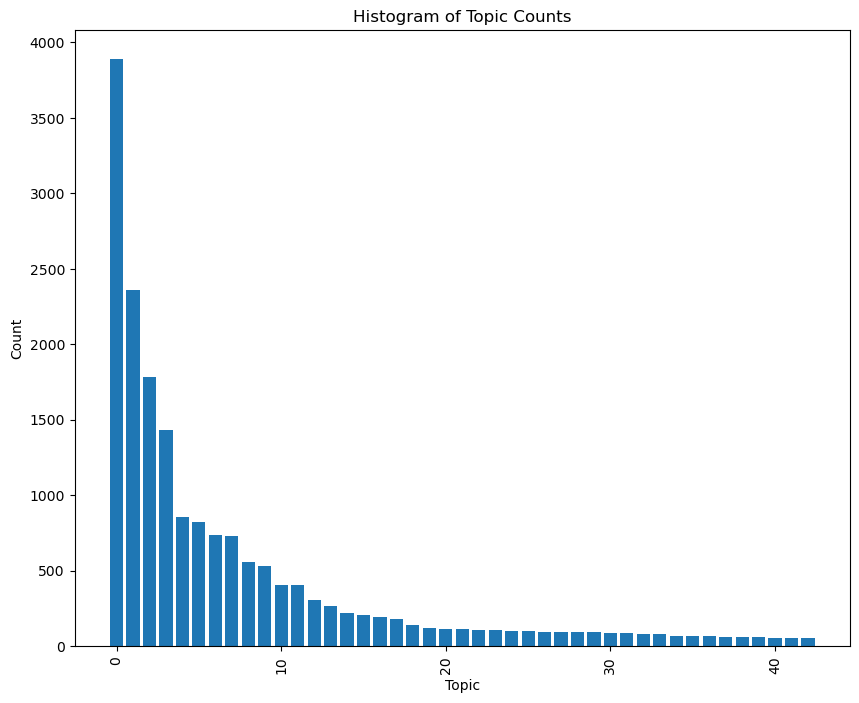

In [18]:
# Sort the topics by Count
topic_info_sorted = topic_info.sort_values(by="Count", ascending=False)

# Plot a bar chart
plt.figure(figsize=(10, 8))
plt.bar(topic_info_sorted['Topic'], topic_info_sorted['Count'])
plt.xlabel('Topic')
plt.ylabel('Count')
plt.title('Histogram of Topic Counts')
plt.xticks(rotation=90)
plt.show()

A characteristic feature of BERTopic's output is that Topic 0 will have the highest frequency, Topic 1 will have the second highest, and so on.

This is visually observed in the histogram above.

The majority of data seems to be within the first 4 topics.

### Transforming Text into Embeddings

To perform further analysis, we first need to convert the plot summaries of our movies into numerical embeddings. To do this, we utilize a sentence transformer model and encode our text data:

In [19]:
# Initialize the sentence transformer
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

# Calculate embeddings
embeddings = sentence_model.encode(df['Plot'].tolist(), convert_to_tensor=True)

# Save embeddings
torch.save(embeddings, "embeddings.pt")

### Extracting Document Info and Filtering Noise

Gathering information about our documents, particularly the topics each document is associated with.

Once again, topic '-1' is excluded as it represents noise.

In [20]:
# Get document info
docs = df['Plot']
T = model_bertopic.get_document_info(docs)

# Exclude rows where the topic is '-1'
T = T[T.Topic != -1]

Organize documents per topic and get an overview of each:

In [21]:
# Get all documents per topic
docs_per_topics = T.groupby(["Topic"]).apply(lambda x: x.index).to_dict()

# Get an overview of the topics
topic_info = model_bertopic.get_topic_info()

### Visualizing Topics in 2D Space

Text(0.5, 1.0, 'UMAP Embedding of Topics')

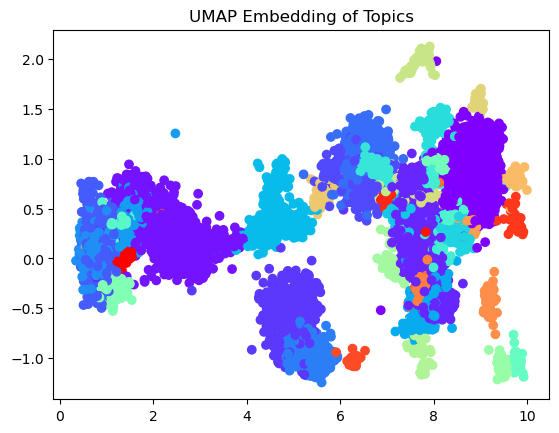

In [22]:
# Exclude row where the topic is '-1'
topic_info = topic_info[topic_info.Topic != -1]

# Get the indices of the documents corresponding to non '-1' topics
non_minus_one_indices = T.index.values

# Get the embeddings for only these documents
non_minus_one_embeddings = embeddings[non_minus_one_indices]

# Apply the UMAP model of model_bertopic
umap_model = model_bertopic.umap_model
u = umap_model.transform(non_minus_one_embeddings)

# Generate a list of colors
colors = plt.cm.rainbow(np.linspace(0, 1, len(docs_per_topics)))
color_dict = {topic: colors[i] for i, topic in enumerate(docs_per_topics)}

# Apply the colors for the documents
doc_colors = [color_dict[topic] for topic in T['Topic']]

# Visualize
plt.scatter(u[:,0], u[:,1], c=doc_colors)
plt.title('UMAP Embedding of Topics')

In the UMAP plot, distinct clusters represent different topics. 

To understand what each cluster represents, we can explore specific topics in more detail:

In [23]:
# Exploring specific topics: 
Bert_topic = 4        #Used 0, 1 , 3, 4 to determine which topic is which and label the above visual

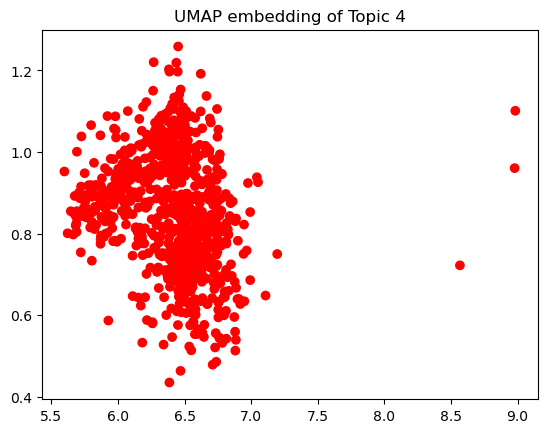

In [24]:
# Reset T to its original value before applying a new filter
T = model_bertopic.get_document_info(docs)
T = T[T.Topic != -1]

# Filter T to only include Bert_topic
T = T[T.Topic == Bert_topic]

# Get all documents per topic
docs_per_topics = T.groupby(["Topic"]).apply(lambda x: x.index).to_dict()

# Get an overview of the topics
topic_info = model_bertopic.get_topic_info()

# Filter topic_info to only include Bert_topic
topic_info = topic_info[topic_info.Topic == Bert_topic]

# Get the indices of the documents corresponding to Bert_topic
non_minus_one_indices = T.index.values

# Get the embeddings for only these documents
non_minus_one_embeddings = embeddings[non_minus_one_indices]

# Apply the UMAP model of model_bertopic
umap_model = model_bertopic.umap_model
u = umap_model.transform(non_minus_one_embeddings)

# Assign a color for Bert_topic
color_dict = {Bert_topic: 'red'}  # Change the color as needed

# Get the color for the documents
doc_colors = [color_dict[topic] for topic in T['Topic']]

# Visualize
plt.scatter(u[:,0], u[:,1], c=doc_colors)
plt.title(f'UMAP embedding of Topic {Bert_topic}')
plt.show()


# Merging Topics generated from Plot onto the dataFrame

In [25]:
document_info = model_bertopic.get_document_info(docs)

In [26]:
document_info

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,bartender working saloon serving drink custome...,4,4_murder_police_detective_crime,"[murder, police, detective, crime, gang, crimi...",[pair brother paid take care confectionery box...,murder - police - detective - crime - gang - c...,0.241017,False
1,moon painted smiling face hang park night youn...,-1,-1_get_find_one_go,"[get, find, one, go, father, take, love, life,...",[start film krishna set fire bullying elder br...,get - find - one - go - father - take - love -...,0.138258,False
2,film minute long composed two shot first girl ...,-1,-1_get_find_one_go,"[get, find, one, go, father, take, love, life,...",[start film krishna set fire bullying elder br...,get - find - one - go - father - take - love -...,0.430619,False
3,lasting 61 second consisting two shot first sh...,-1,-1_get_find_one_go,"[get, find, one, go, father, take, love, life,...",[start film krishna set fire bullying elder br...,get - find - one - go - father - take - love -...,0.463396,False
4,earliest known adaptation classic fairytale fi...,-1,-1_get_find_one_go,"[get, find, one, go, father, take, love, life,...",[start film krishna set fire bullying elder br...,get - find - one - go - father - take - love -...,0.910524,False
...,...,...,...,...,...,...,...,...
34881,film begin 1919 world war ended centre around ...,-1,-1_get_find_one_go,"[get, find, one, go, father, take, love, life,...",[start film krishna set fire bullying elder br...,get - find - one - go - father - take - love -...,0.727347,False
34882,two musician salih gürkan described adventure ...,-1,-1_get_find_one_go,"[get, find, one, go, father, take, love, life,...",[start film krishna set fire bullying elder br...,get - find - one - go - father - take - love -...,0.146183,False
34883,zafer sailor living mother döndü coastal villa...,1,1_love_story_life_film,"[love, story, life, film, village, family, fal...",[story open car accident rupa nargis bagheri p...,love - story - life - film - village - family ...,0.562993,False
34884,film centre around young woman named amy tyler...,-1,-1_get_find_one_go,"[get, find, one, go, father, take, love, life,...",[start film krishna set fire bullying elder br...,get - find - one - go - father - take - love -...,0.208944,False


In [27]:
df = df.merge(document_info, left_on='Plot', right_on='Document', how='left')

Check that the merge was successful and no mistakes occured during merging

In [28]:
df.head(5)

,Release Year,Title,Plot,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,1901,Kansas Saloon Smashers,bartender working saloon serving drink custome...,bartender working saloon serving drink custome...,4,4_murder_police_detective_crime,"[murder, police, detective, crime, gang, crimi...",[pair brother paid take care confectionery box...,murder - police - detective - crime - gang - c...,0.241017,False
1,1901,Love by the Light of the Moon,moon painted smiling face hang park night youn...,moon painted smiling face hang park night youn...,-1,-1_get_find_one_go,"[get, find, one, go, father, take, love, life,...",[start film krishna set fire bullying elder br...,get - find - one - go - father - take - love -...,0.138258,False
2,1901,The Martyred Presidents,film minute long composed two shot first girl ...,film minute long composed two shot first girl ...,-1,-1_get_find_one_go,"[get, find, one, go, father, take, love, life,...",[start film krishna set fire bullying elder br...,get - find - one - go - father - take - love -...,0.430619,False
3,1901,"Terrible Teddy, the Grizzly King",lasting 61 second consisting two shot first sh...,lasting 61 second consisting two shot first sh...,-1,-1_get_find_one_go,"[get, find, one, go, father, take, love, life,...",[start film krishna set fire bullying elder br...,get - find - one - go - father - take - love -...,0.463396,False
4,1902,Jack and the Beanstalk,earliest known adaptation classic fairytale fi...,earliest known adaptation classic fairytale fi...,-1,-1_get_find_one_go,"[get, find, one, go, father, take, love, life,...",[start film krishna set fire bullying elder br...,get - find - one - go - father - take - love -...,0.910524,False


In [29]:
null_counts = df.isnull().sum()
null_counts

Release Year               0
Title                      0
Plot                       0
Document                   0
Topic                      0
Name                       0
Representation             0
Representative_Docs        0
Top_n_words                0
Probability                0
Representative_document    0
dtype: int64

In [30]:
df.shape

(37070, 11)

In [31]:
# Remove topic -1, which is noise
df = df[df['Topic'] != -1]

In [32]:
df.shape

(18834, 11)

In [33]:
df.head(5)

,Release Year,Title,Plot,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,1901,Kansas Saloon Smashers,bartender working saloon serving drink custome...,bartender working saloon serving drink custome...,4,4_murder_police_detective_crime,"[murder, police, detective, crime, gang, crimi...",[pair brother paid take care confectionery box...,murder - police - detective - crime - gang - c...,0.241017,False
9,1905,The Night Before Christmas,scene introduced using line poem2 santa claus ...,scene introduced using line poem2 santa claus ...,39,39_scrooge_christmas_santa_claus,"[scrooge, christmas, santa, claus, elf, fred, ...",[christmas eve 19th century london charles dic...,scrooge - christmas - santa - claus - elf - fr...,1.000000,False
12,1906,Kathleen Mavourneen,irish villager kathleen tenant captain clearfi...,irish villager kathleen tenant captain clearfi...,30,30_described_film_magazine3_husband,"[described, film, magazine3, husband, return, ...",[described film magazine3 senior john l logan ...,described - film - magazine3 - husband - retur...,0.465372,False
20,1908,A Christmas Carol,print first american film adaptation christmas...,print first american film adaptation christmas...,39,39_scrooge_christmas_santa_claus,"[scrooge, christmas, santa, claus, elf, fred, ...",[christmas eve 19th century london charles dic...,scrooge - christmas - santa - claus - elf - fr...,1.000000,False
25,1909,The Lure of the Gown,story told moving picture world read,story told moving picture world read,11,11_film_story_life_love,"[film, story, life, love, family, young, man, ...",[film tell story friendship love campus film n...,film - story - life - love - family - young - ...,0.352441,False


# Modifying df to export Bertopic results

In [34]:
df = df.drop(['Document', 'Representative_document'], axis=1)

In [35]:
df.to_csv('movie_BERTopic_df.csv', index=False)

In [36]:
# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Reshape the 'Topic' column to a 2D array
topics = df['Topic'].values.reshape(-1, 1)

# One-hot encode the 'Topic' column
one_hot = encoder.fit_transform(topics)

In [37]:
one_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [38]:
num_topics = 44    #num_topics is hardcoded to this variable, switch if model modifcations made

In [39]:
# Convert the one-hot encoded array to a DataFrame
one_hot_df = pd.DataFrame(one_hot, columns=['Bertopic_' + str(i) for i in range(num_topics - 1)])

# Reset the index of both DataFrames
df.reset_index(drop=True, inplace=True)
one_hot_df.reset_index(drop=True, inplace=True)

# Join the one-hot encoded DataFrame back to the original DataFrame
merged_df = df.join(one_hot_df)

In [40]:
merged_df

,Release Year,Title,Plot,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Bertopic_0,...,Bertopic_33,Bertopic_34,Bertopic_35,Bertopic_36,Bertopic_37,Bertopic_38,Bertopic_39,Bertopic_40,Bertopic_41,Bertopic_42
0,1901,Kansas Saloon Smashers,bartender working saloon serving drink custome...,4,4_murder_police_detective_crime,"[murder, police, detective, crime, gang, crimi...",[pair brother paid take care confectionery box...,murder - police - detective - crime - gang - c...,0.241017,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1905,The Night Before Christmas,scene introduced using line poem2 santa claus ...,39,39_scrooge_christmas_santa_claus,"[scrooge, christmas, santa, claus, elf, fred, ...",[christmas eve 19th century london charles dic...,scrooge - christmas - santa - claus - elf - fr...,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1906,Kathleen Mavourneen,irish villager kathleen tenant captain clearfi...,30,30_described_film_magazine3_husband,"[described, film, magazine3, husband, return, ...",[described film magazine3 senior john l logan ...,described - film - magazine3 - husband - retur...,0.465372,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1908,A Christmas Carol,print first american film adaptation christmas...,39,39_scrooge_christmas_santa_claus,"[scrooge, christmas, santa, claus, elf, fred, ...",[christmas eve 19th century london charles dic...,scrooge - christmas - santa - claus - elf - fr...,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1909,The Lure of the Gown,story told moving picture world read,11,11_film_story_life_love,"[film, story, life, love, family, young, man, ...",[film tell story friendship love campus film n...,film - story - life - love - family - young - ...,0.352441,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18829,2013,Particle (film),zeynep lost job weaving factory family mother ...,1,1_love_story_life_film,"[love, story, life, film, village, family, fal...",[story open car accident rupa nargis bagheri p...,love - story - life - film - village - family ...,0.385919,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18830,2014,Mandıra Filozofu,cavit ambitious industralist i̇stanbul plan bu...,1,1_love_story_life_film,"[love, story, life, film, village, family, fal...",[story open car accident rupa nargis bagheri p...,love - story - life - film - village - family ...,0.182294,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18831,2014,Winter Sleep,aydın former actor owns mountaintop hotel capp...,5,5_love_get_family_father,"[love, get, family, father, marriage, raja, ma...",[story start vasu vaibhav narrating story chil...,love - get - family - father - marriage - raja...,0.207084,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18832,2017,Olanlar Oldu,zafer sailor living mother döndü coastal villa...,1,1_love_story_life_film,"[love, story, life, film, village, family, fal...",[story open car accident rupa nargis bagheri p...,love - story - life - film - village - family ...,0.562993,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
merged_df = merged_df.drop(['Plot', 'Representative_Docs', 'Top_n_words', 'Name', 'Representation'], axis=1)

In [42]:
merged_df

,Release Year,Title,Topic,Probability,Bertopic_0,Bertopic_1,Bertopic_2,Bertopic_3,Bertopic_4,Bertopic_5,...,Bertopic_33,Bertopic_34,Bertopic_35,Bertopic_36,Bertopic_37,Bertopic_38,Bertopic_39,Bertopic_40,Bertopic_41,Bertopic_42
0,1901,Kansas Saloon Smashers,4,0.241017,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1905,The Night Before Christmas,39,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1906,Kathleen Mavourneen,30,0.465372,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1908,A Christmas Carol,39,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1909,The Lure of the Gown,11,0.352441,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18829,2013,Particle (film),1,0.385919,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18830,2014,Mandıra Filozofu,1,0.182294,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18831,2014,Winter Sleep,5,0.207084,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18832,2017,Olanlar Oldu,1,0.562993,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now the final df contains Release Year, Title, Topic (generated via BERTopic), Probability (of it being the topic), and OHE of the topics.

In [43]:
merged_df.to_csv('movie_BERTopic_OHE_df.csv', index=False)

This CSV will be later used in in the Predicting Topic Plots jupyter notebook.